# MLP class

In [110]:
import numpy as np
from sklearn.metrics import f1_score

In [111]:
import copy

class MLP:
    def __init__(self, layer_sizes, act_fun, out_act_fun_name = 'linear', loss_fun_name = 'mse', metric = 'mse'):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_name)
        self.set_loss_fun(loss_fun_name)
        self.metric = metric
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.random.rand(self.layer_sizes[i + 1], 1)        

    def _forward(self, X, return_activations = False):
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        Y = X
        if return_activations: A = []

        for i in range(self.n_layers - 2):
            Y = np.dot(Y, self.weights[i]) + self.biases[i].T
            if return_activations:
                A.append(Y)
            Y = self.act_fun(Y)
        Y = np.dot(Y, self.weights[-1]) + self.biases[-1].T
        if return_activations:
            A.append(Y)
        Y = self.out_act_fun(Y)
        return Y if not return_activations else (Y, A)

    def predict(self, X):
        return self._forward(X)
    
    def _backward(self, X, Y, batch_size):
        Y = np.atleast_2d(Y)
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        if Y.shape[0] == 1:
            Y = Y.reshape(-1, 1)
        Y_pred, A = self._forward(X, return_activations = True)
        error = Y_pred - Y
        D_weights = []
        D_biases = []
        E = np.array([])
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                if self.loss_fun_name == 'cross_entropy' and self.out_act_fun_name == 'softmax':
                    E = error
                elif self.loss_fun_name == 'mse':
                    E = error * self.out_act_fun_prime(A[i])
            else:
                E = np.dot(E, self.weights[i + 1].T) * self.act_fun_prime(A[i])
            D_weights.insert(0, np.dot(self.act_fun(A[i - 1]).T, E) / batch_size if i > 0 else np.dot(X.T, E) / batch_size)
            D_biases.insert(0, np.sum(E, axis=0).reshape(-1, 1) / batch_size)
        return D_weights, D_biases
        

    def _momentum_update(self, D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate):
        for i in range(len(self.weights)):
            momentum_w[i] = - D_weights[i] + momentum_coef * momentum_w[i]
            momentum_b[i] = - D_biases[i] + momentum_coef * momentum_b[i]
            self.weights[i] += learning_rate * momentum_w[i]
            self.biases[i] += learning_rate * momentum_b[i]
        return momentum_w, momentum_b
    
    def _RMSProp_update(self, D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate):
        for i in range(len(self.weights)):
            E_w[i] = beta * E_w[i] + (1 - beta) * D_weights[i] ** 2
            E_b[i] = beta * E_b[i] + (1 - beta) * D_biases[i] ** 2
            self.weights[i] -= learning_rate * D_weights[i] / (np.sqrt(E_w[i] + epsilon))
            self.biases[i] -= learning_rate * D_biases[i] / (np.sqrt(E_b[i] + epsilon))
        return E_w, E_b
    
    def fit(self, X, Y, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, epochs = 100, n_epochs_displayed = 100, optimizer=None, beta=0.9, epsilon=1e-8, track_weights=False, batch_size=32, return_metrics=False):
        X = np.array(X)
        Y = np.array(Y)
        losses = []
        metrics = []
        if track_weights:
            weights_over_epochs = [copy.deepcopy(self.weights)]
            biases_over_epochs = [copy.deepcopy(self.biases)]
        else:
            weights_over_epochs = []
            biases_over_epochs = []
            
        if optimizer == 'momentum':
            momentum_w = [np.zeros(w.shape) for w in self.weights]
            momentum_b = [np.zeros(b.shape) for b in self.biases]

        if optimizer == 'RMSProp':
            E_w = [np.zeros(w.shape) for w in self.weights]
            E_b = [np.zeros(b.shape) for b in self.biases]

        for epoch in range(epochs):
            permutaion = np.random.permutation(X.shape[0])
            learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            for i in range(0, X.shape[0], batch_size):
                D_weights, D_biases = self._backward(X[permutaion[i:i + batch_size]], Y[permutaion[i:i + batch_size]], batch_size)

                if not optimizer:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * D_weights[j]
                        self.biases[j] -= learning_rate * D_biases[j]
                elif optimizer == 'momentum':
                    momentum_w, momentum_b = self._momentum_update(D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate)
                elif optimizer == 'RMSProp':
                    E_w, E_b = self._RMSProp_update(D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate)
            Y_pred = self.predict(X)
            losses.append(self.loss_fun(Y, Y_pred))
            if return_metrics:
                if self.metric == 'f1':
                    metrics.append(f1_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1), average="macro"))
            if track_weights:
                weights_over_epochs.append(copy.deepcopy(self.weights))
                biases_over_epochs.append(copy.deepcopy(self.biases))
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                if self.metric == 'mse':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
                elif self.metric == 'f1':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}, f1_score={f1_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1), average="macro")}')
        if track_weights and return_metrics:
            return losses, metrics, weights_over_epochs, biases_over_epochs
        elif track_weights:
            return losses, weights_over_epochs, biases_over_epochs
        elif return_metrics:
            return losses, metrics    
                
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        act_fun_prime = None
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)
            act_fun_prime = lambda x: np.where(x > 0, 1, 0)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            act_fun_prime = lambda x: 1 - np.tanh(x) ** 2
            
        self.act_fun = act_fun
        self.act_fun_prime = act_fun_prime

    def set_out_act_fun(self, out_act_fun_name):
        if not out_act_fun_name:
            out_act_fun_name = 'linear'
        if out_act_fun_name == 'linear':
            out_act_fun = lambda x: x
            out_act_fun_prime = lambda x: np.ones_like(x)
        elif out_act_fun_name == 'softmax':
            out_act_fun = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
            out_act_fun_prime = lambda x: np.exp(x) * (1 - np.exp(x)) / np.sum(np.exp(x), axis=1, keepdims=True) ** 2
        self.out_act_fun_name = out_act_fun_name
        self.out_act_fun = out_act_fun
        self.out_act_fun_prime = out_act_fun_prime

    def set_loss_fun(self, loss_fun_name):
        self.loss_fun_name = loss_fun_name
        def _mse(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return np.mean((y - y_pred) ** 2) / 2
        
        def _cross_entropy(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))
        
        if loss_fun_name == 'mse':
            self.loss_fun = lambda y, y_pred: _mse(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: y_pred - y
        elif loss_fun_name == 'cross_entropy':
            self.loss_fun = lambda y, y_pred: _cross_entropy(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: - (y / (y_pred + 1e-15)) / y.shape[0]
    

    

    

In [112]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data, axis=0)

    if max is None:
        max = np.max(data, axis=0)

    return (data - min) / (max - min), min, max    

In [113]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualisation

In [114]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [115]:
def draw_network_for_epoch(weights, biases, epoch):
    G = nx.Graph()
    n_layers = len(weights) + 1
    n_neurons = [len(layer) for layer in weights] + [len(biases[-1])]

    max_abs_weight = max([np.max(np.abs(layer)) for layer in weights])

    for i in range(n_layers):
        for j in range(n_neurons[i]):
            G.add_node(f'{i}-{j}')
    for i in range(n_layers - 1):
        for j in range(n_neurons[i]):
            for k in range(n_neurons[i + 1]):
                G.add_edge(f'{i}-{j}', f'{i + 1}-{k}', weight=weights[i][j][k])
    
    pos = {}
    max_n_neurons = max(n_neurons)
    for i in range(n_layers):
        for j in range(n_neurons[i]):
            pos[f'{i}-{j}'] = (i, max_n_neurons - n_neurons[i] + 2 * j)
    
    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=-max_abs_weight, vmax=max_abs_weight)
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]

    plt.figure(figsize=(10, 10))
    plt.title(f'Epoch {epoch}')
    nx.draw(
        G, 
        pos,
        edge_color=edge_colors,
        node_size=3000, 
        font_size=10, 
        width=[abs(G[u][v]['weight']) + 1 for u, v in G.edges()]
    )
    node_labels = {f'{i+1}-{j}': f'{biases[i][j][0]:.2f}' for i in range(n_layers - 1) for j in range(n_neurons[i + 1])}
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()})
    plt.show()

In [116]:
def draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, epochs):
    for epoch in epochs:
        draw_network_for_epoch(weights_over_epochs[epoch], biases_over_epochs[epoch], epoch)

In [117]:
def train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, first_lr, epochs, lr_decay_rate=0, n_epochs_displayed = 100, batch_size = 32, momentum_coef = 0.9, beta = 0.9, epsilon = 1e-8, optimizer=None, return_metrics=False):
    
    X_train_norm, x_min, x_max = normalize(X_train)
    if model.loss_fun_name == 'mse':
        Y_train_norm, y_min, y_max = normalize(Y_train)
    else:
        Y_train_norm = pd.get_dummies(Y_train)
    X_test_norm, _, _ = normalize(X_test, x_min, x_max)

    losses, metrics, weights_over_epochs, biases_over_epochs = model.fit(X_train_norm, Y_train_norm, first_lr=first_lr, lr_decay_rate=lr_decay_rate, momentum_coef=momentum_coef, 
                                                                    epochs=epochs, n_epochs_displayed=n_epochs_displayed, optimizer=optimizer, beta=beta, epsilon=epsilon,
                                                                    track_weights=True, batch_size=batch_size, return_metrics=return_metrics)
    
    if model.loss_fun_name == 'mse':
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_train, Y_train, color='blue', label='true')
        ax[0].scatter(X_train, denormalize(model.predict(X_train_norm), y_min, y_max), color='red', label='prediction')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Denormalised train data')
        ax[0].legend()

        ax[1].plot(range(epochs), losses)
        ax[1].set_yscale('log')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('normalized MSE (log scale)')
        ax[1].set_title(f'Denormalised train set MSE={model.loss_fun(Y_train, denormalize(model.predict(X_train_norm), y_min, y_max)):.2f}')
        plt.show()

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_test, Y_test, color='blue', label='true')
        ax[0].scatter(X_test, denormalize(model.predict(X_test_norm), y_min, y_max), color='red', label='prediction')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Denormalised test data')
        ax[0].legend()

        ax[1].text(0.5, 0.5, f'Denormalised test set MSE={model.loss_fun(Y_test, denormalize(model.predict(X_test_norm), y_min, y_max)):.2f}', fontsize=15, ha='center')
        ax[1].axis('off')

        plt.show()

    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        # color_map = {0: 'blue', 1: 'oragne', 2: 'green'}

        # colors = [color_map[i] for i in Y_train]
        ax[0].scatter(X_train['x'], X_train['y'], c=Y_train)
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Train data')
        # ax[0].legend()
        
        ax[1].scatter(X_train['x'], X_train['y'], c=np.argmax(model.predict(X_train_norm), axis=1))
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        ax[1].set_title('Train data prediction')
        # ax[1].legend()

        ax[2].plot(range(epochs), losses)
        ax[2].set_yscale('log')
        ax[2].set_xlabel('epoch')
        ax[2].set_ylabel('cross entropy (log scale)')
        ax[2].set_title(f'Train set F1-score={f1_score(Y_train, np.argmax(model.predict(X_train_norm), axis=1), average="macro"):.2f}')

        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        # color_map = {0: 'blue', 1: 'oragne', 2: 'green'}

        # colors = [color_map[i] for i in Y_train]
        ax[0].scatter(X_test['x'], X_test['y'], c=Y_test)
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Test data')
        # ax[0].legend()
        
        ax[1].scatter(X_test['x'], X_test['y'], c=np.argmax(model.predict(X_test_norm), axis=1))
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        ax[1].set_title('Test data prediction')
        # ax[1].legend()

        ax[2].text(0.5, 0.5, f'Test set F1-score={f1_score(Y_test, np.argmax(model.predict(X_test_norm), axis=1), average="macro"):.2f}', fontsize=15, ha='center')

        plt.show()

    return losses, metrics, weights_over_epochs, biases_over_epochs
    


# rings3-regular 

In [118]:
X_train = pd.read_csv('data/classification/rings3-regular-training.csv', index_col=None)[['x', 'y']]
Y_train = pd.read_csv('data/classification/rings3-regular-training.csv', index_col=None)['c']
X_test = pd.read_csv('data/classification/rings3-regular-test.csv', index_col=None)[['x', 'y']]
Y_test = pd.read_csv('data/classification/rings3-regular-test.csv', index_col=None)['c']

In [119]:
epochs = 1500
first_lr = 0.1

## softmax

In [120]:
model_root_softmax = MLP([2, 10, 10, 3], 'sigmoid', 'softmax', 'cross_entropy', 'f1')

Epoch 1: loss_fun=1.1271007123093868, f1_score=0.16666666666666666
Epoch 100: loss_fun=0.7307452637728329, f1_score=0.6460520017863973
Epoch 200: loss_fun=0.28663530245750923, f1_score=0.8687001731592158
Epoch 300: loss_fun=0.1898824241601008, f1_score=0.9217558279925795
Epoch 400: loss_fun=0.17636984140663234, f1_score=0.9331016095062447
Epoch 500: loss_fun=0.17891034801891162, f1_score=0.9219592828112745
Epoch 600: loss_fun=0.13999897173373807, f1_score=0.9373772742567357
Epoch 700: loss_fun=0.10729271890202523, f1_score=0.9531947186618872
Epoch 800: loss_fun=0.0850033931633617, f1_score=0.9660513086558916
Epoch 900: loss_fun=0.07524457480230094, f1_score=0.9673363755502266
Epoch 1000: loss_fun=0.11482873484123517, f1_score=0.9440419836275256
Epoch 1100: loss_fun=0.07414560880042913, f1_score=0.9673839336691238
Epoch 1200: loss_fun=0.1535359203854887, f1_score=0.9399973767942646
Epoch 1300: loss_fun=0.06154770254106442, f1_score=0.9760242500559992
Epoch 1400: loss_fun=0.0524473786396

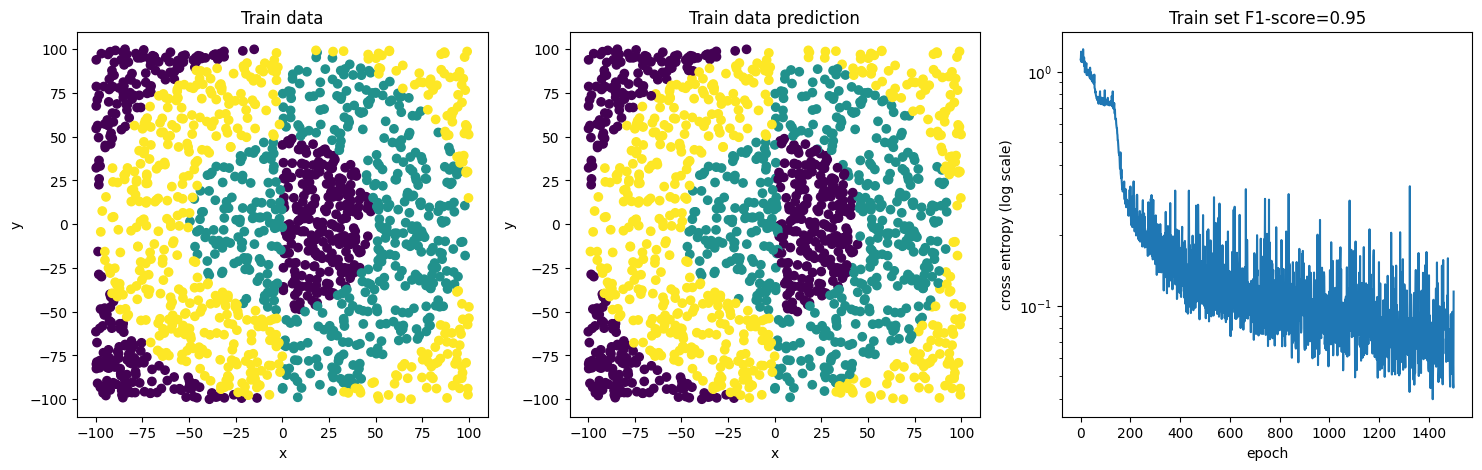

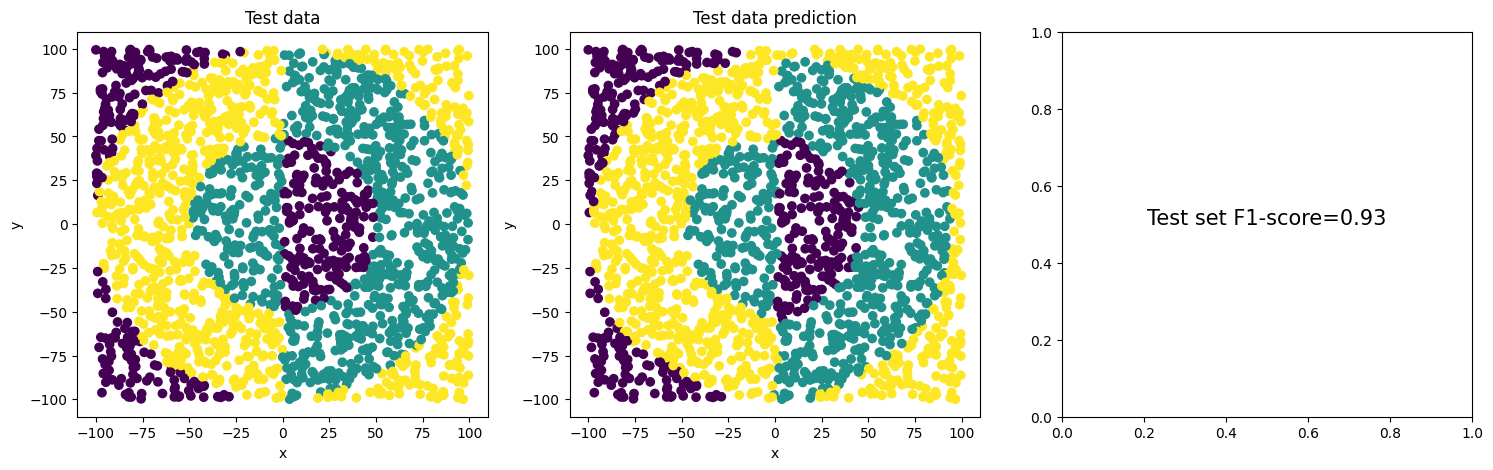

In [121]:
model_softmax = copy.deepcopy(model_root_softmax)
losses_softmax, f1_softmax, _, _ = train_and_draw_plots(model_softmax, X_train, Y_train, X_test, Y_test, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True)

## linear

In [122]:
model_root_linear = MLP([2, 10, 10, 3], 'sigmoid', 'linear', 'mse', 'f1')

In [123]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_onehot = pd.get_dummies(Y_train)

In [124]:
model_linear = copy.deepcopy(model_root_linear)
losses_linear, f1_linear = model_linear.fit(X_train_norm, Y_train_onehot, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum',return_metrics=True)

Epoch 1: loss_fun=0.11416768434903113, f1_score=0.16666666666666666
Epoch 100: loss_fun=0.12751165902659406, f1_score=0.16666666666666666
Epoch 200: loss_fun=0.1136780512588513, f1_score=0.16666666666666666
Epoch 300: loss_fun=0.1114160214881927, f1_score=0.16666666666666666
Epoch 400: loss_fun=0.11258663882766892, f1_score=0.16666666666666666
Epoch 500: loss_fun=0.11254113289829405, f1_score=0.16666666666666666
Epoch 600: loss_fun=0.11134576342005952, f1_score=0.16666666666666666
Epoch 700: loss_fun=0.11136682931835339, f1_score=0.16666666666666666
Epoch 800: loss_fun=0.11142804704072391, f1_score=0.16666666666666666
Epoch 900: loss_fun=0.10031908503351541, f1_score=0.5353332434523784
Epoch 1000: loss_fun=0.09945706890146862, f1_score=0.3916592530751081
Epoch 1100: loss_fun=0.09925055581473534, f1_score=0.3589592374069744
Epoch 1200: loss_fun=0.09937128311502055, f1_score=0.4786048807959476
Epoch 1300: loss_fun=0.09920234734383136, f1_score=0.49720209763184803
Epoch 1400: loss_fun=0.0

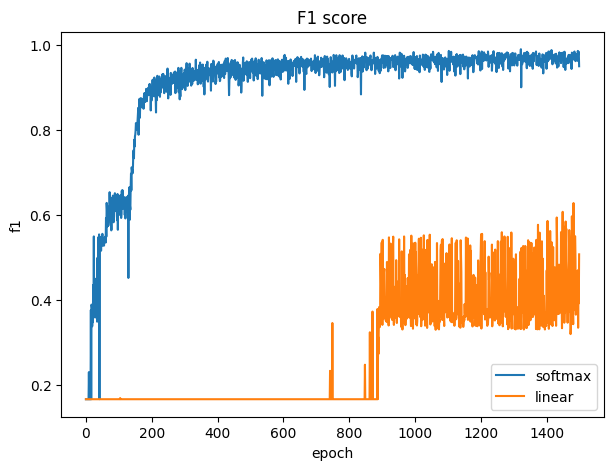

In [125]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(epochs), f1_softmax, label='softmax')
ax.plot(range(epochs), f1_linear, label='linear')
# ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('f1')
ax.set_title('F1 score')
ax.legend()
plt.show()

# easy

In [126]:
X_train = pd.read_csv('data/classification/easy-training.csv', index_col=None)[['x', 'y']]
Y_train = pd.read_csv('data/classification/easy-training.csv', index_col=None)['c'].astype('int')
X_test = pd.read_csv('data/classification/easy-test.csv', index_col=None)[['x', 'y']]
Y_test = pd.read_csv('data/classification/easy-test.csv', index_col=None)['c'].astype('int')

In [127]:
model_root_softmax = MLP([2, 10, 10, 2], 'sigmoid', 'softmax', 'cross_entropy', 'f1')

In [128]:
epochs = 1500
first_lr = 0.1

## softmax

Epoch 1: loss_fun=0.7978673875941383, f1_score=0.3333333333333333
Epoch 100: loss_fun=0.05636797315889717, f1_score=0.9719780307761285
Epoch 200: loss_fun=0.07638252926841411, f1_score=0.9679671984111731
Epoch 300: loss_fun=0.013366104602909388, f1_score=0.9939997839922237
Epoch 400: loss_fun=0.014603791153140401, f1_score=0.9939997839922237
Epoch 500: loss_fun=0.012664823673190002, f1_score=0.9939997839922237
Epoch 600: loss_fun=0.020416207317044594, f1_score=0.9879982717511322
Epoch 700: loss_fun=0.02797391286926383, f1_score=0.9839959029511556
Epoch 800: loss_fun=0.006593414543065028, f1_score=1.0
Epoch 900: loss_fun=0.012571890930059325, f1_score=0.995999935998976
Epoch 1000: loss_fun=0.0077560435197987585, f1_score=0.997999991999968
Epoch 1100: loss_fun=0.014826302614588427, f1_score=0.995999935998976
Epoch 1200: loss_fun=0.006980736826800571, f1_score=0.997999991999968
Epoch 1300: loss_fun=0.018449983312888572, f1_score=0.9879982717511322
Epoch 1400: loss_fun=0.010343818248151919

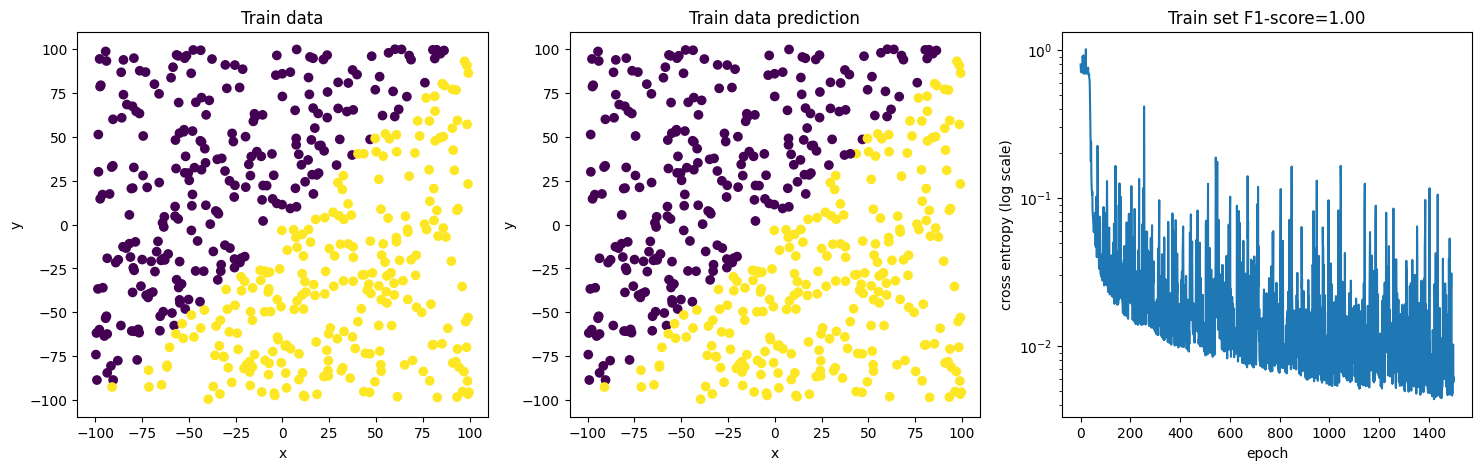

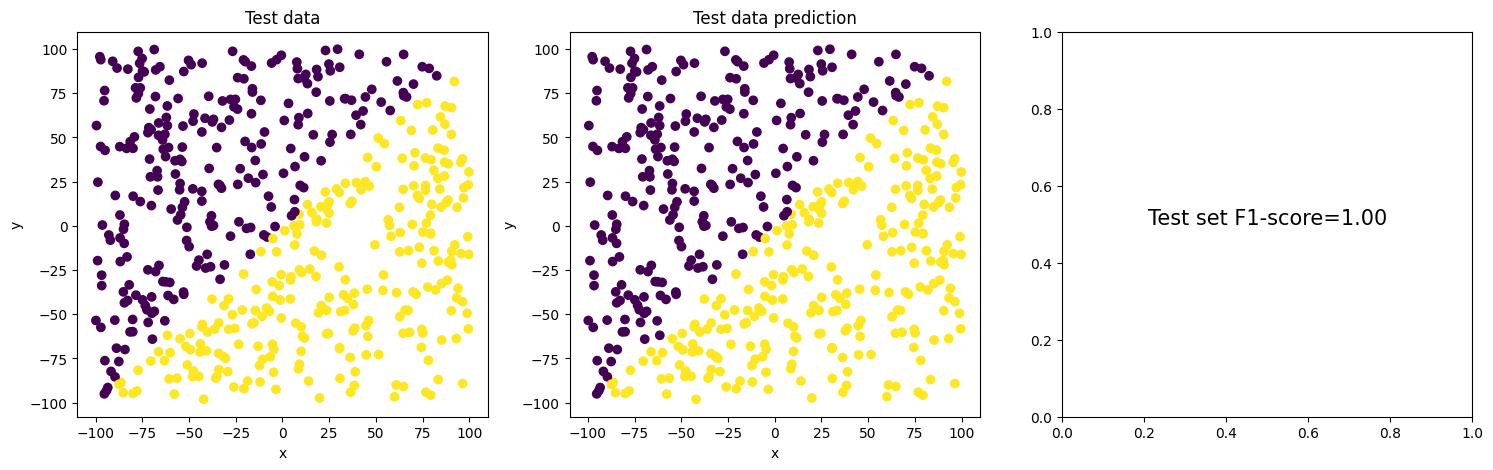

In [129]:
model_softmax = copy.deepcopy(model_root_softmax)
losses, f1_softmax, _, _ = train_and_draw_plots(model_softmax, X_train, Y_train, X_test, Y_test, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True)

## linear

In [130]:
model_root_linear = MLP([2, 10, 10, 2], 'sigmoid', 'linear', 'mse', 'f1')

In [131]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_onehot = pd.get_dummies(Y_train)

In [132]:
model_linear = copy.deepcopy(model_root_linear)
losses_linear, f1_linear = model_linear.fit(X_train_norm, Y_train_onehot, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum',return_metrics=True)

Epoch 1: loss_fun=1.4586724277377159, f1_score=0.3333333333333333
Epoch 100: loss_fun=0.01699412376794739, f1_score=0.9879982717511322
Epoch 200: loss_fun=0.00788092066195517, f1_score=0.9919994879672299
Epoch 300: loss_fun=0.006269032266818993, f1_score=0.996
Epoch 400: loss_fun=0.00531171701535684, f1_score=0.9899989998999901
Epoch 500: loss_fun=0.004745985225566597, f1_score=0.9899989998999901
Epoch 600: loss_fun=0.004227113855990898, f1_score=0.9939997839922237
Epoch 700: loss_fun=0.003802052510028659, f1_score=0.995999935998976
Epoch 800: loss_fun=0.004268106965002292, f1_score=0.997999991999968
Epoch 900: loss_fun=0.004264244322402577, f1_score=1.0
Epoch 1000: loss_fun=0.0031568440979104838, f1_score=0.997999991999968
Epoch 1100: loss_fun=0.0029762357263450755, f1_score=0.997999991999968
Epoch 1200: loss_fun=0.002743242656299455, f1_score=0.997999991999968
Epoch 1300: loss_fun=0.002718052732215936, f1_score=0.995999935998976
Epoch 1400: loss_fun=0.002523035757675581, f1_score=0.9

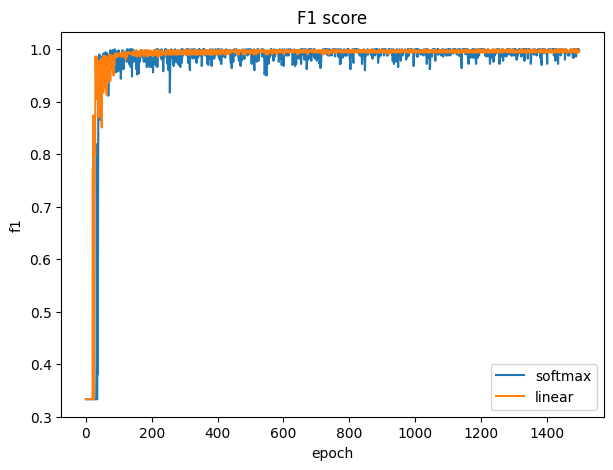

In [133]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(epochs), f1_softmax, label='softmax')
ax.plot(range(epochs), f1_linear, label='linear')
# ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('f1')
ax.set_title('F1 score')
ax.legend()
plt.show()

# xor3

In [192]:
X_train = pd.read_csv('data/classification/xor3-training.csv', index_col=None)[['x', 'y']]
Y_train = pd.read_csv('data/classification/xor3-training.csv', index_col=None)['c']
X_test = pd.read_csv('data/classification/xor3-test.csv', index_col=None)[['x', 'y']]
Y_test = pd.read_csv('data/classification/xor3-test.csv', index_col=None)['c']

## softmax

In [217]:
model_root_softmax = MLP([2, 10, 10, 2], 'sigmoid', 'softmax', 'cross_entropy', metric='f1')

In [218]:
epochs = 5000
first_lr = 0.8

Epoch 1: loss_fun=1.7038866786459677, f1_score=0.3333333333333333
Epoch 100: loss_fun=0.6943415526864501, f1_score=0.3333333333333333
Epoch 200: loss_fun=0.961549748715805, f1_score=0.3333333333333333
Epoch 300: loss_fun=0.7640395871676644, f1_score=0.3333333333333333
Epoch 400: loss_fun=0.7208518034073812, f1_score=0.3333333333333333
Epoch 500: loss_fun=0.6919031841379483, f1_score=0.4646169142813438
Epoch 600: loss_fun=0.7559872325058667, f1_score=0.5450409463148317
Epoch 700: loss_fun=0.41484139301630163, f1_score=0.7815377338448156
Epoch 800: loss_fun=0.16231129586280757, f1_score=0.9358522034768106
Epoch 900: loss_fun=0.21650276525237241, f1_score=0.9358522034768106
Epoch 1000: loss_fun=0.09274028072411092, f1_score=0.9719928301645222
Epoch 1100: loss_fun=0.1296660475331928, f1_score=0.9479991679866878
Epoch 1200: loss_fun=0.08952242667853476, f1_score=0.9679871948779513
Epoch 1300: loss_fun=0.15868456641615197, f1_score=0.9639792520491803
Epoch 1400: loss_fun=0.04745210530511497,

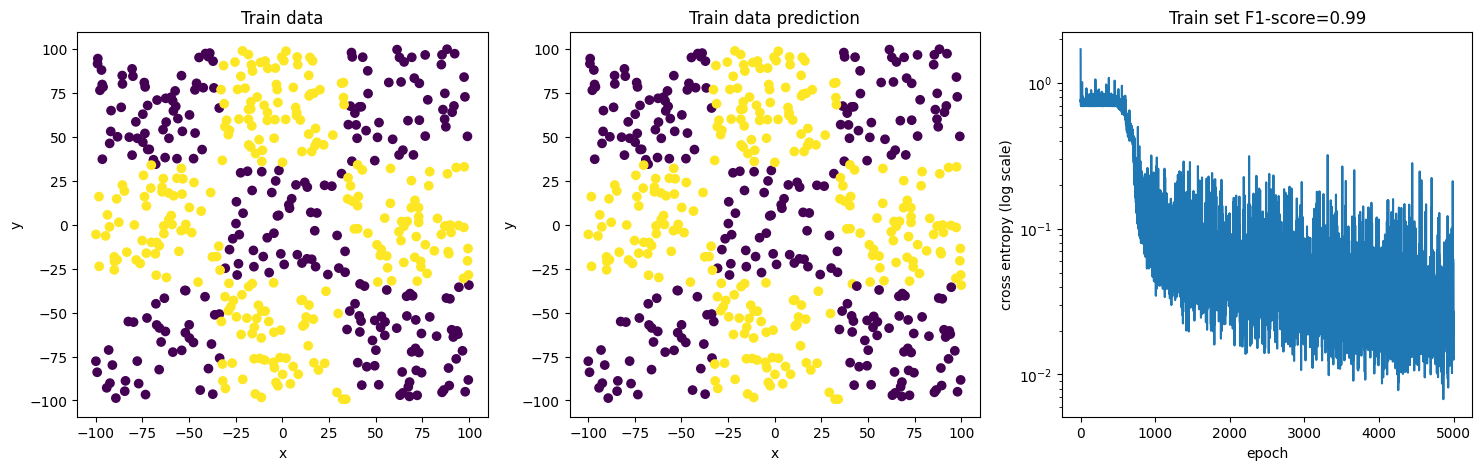

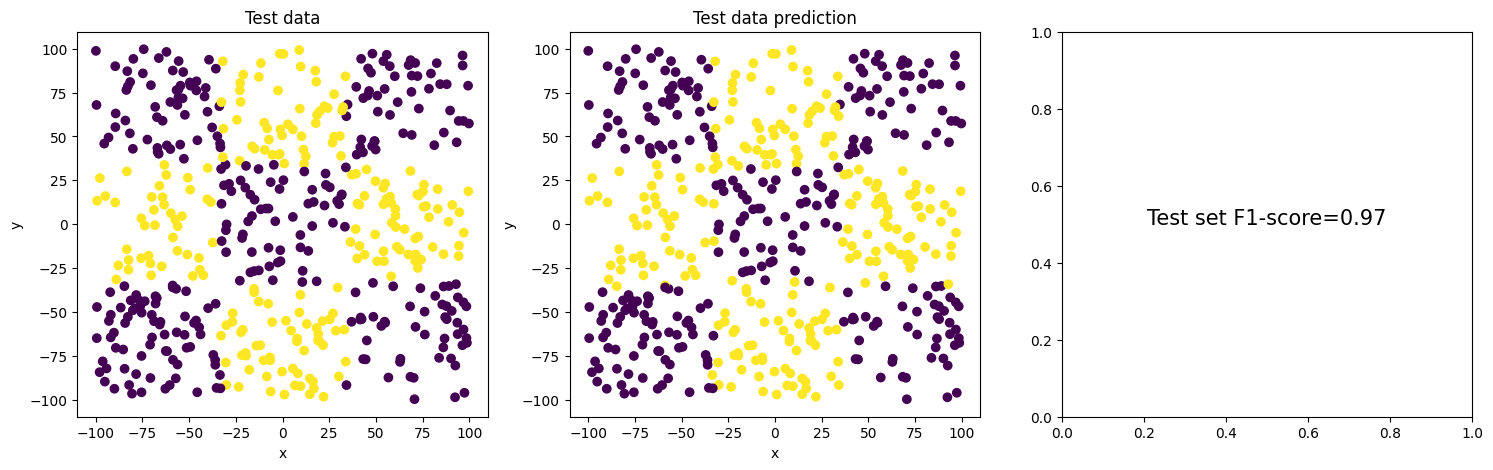

In [219]:
model_softmax = copy.deepcopy(model_root_softmax)
losses, f1_softmax, _, _ = train_and_draw_plots(model_softmax, X_train, Y_train, X_test, Y_test, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, optimizer='momentum', momentum_coef=0.9, lr_decay_rate=0, return_metrics=True)

## linear

In [232]:
model_root_linear = MLP([2, 10, 10, 2], 'sigmoid', 'linear', 'mse', 'f1')

In [233]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_onehot = pd.get_dummies(Y_train)

In [237]:
model_linear = copy.deepcopy(model_root_linear)
losses_linear, f1_linear = model_linear.fit(X_train_norm, Y_train_onehot, first_lr=0.3, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum',return_metrics=True)

Epoch 1: loss_fun=0.23128249707509735, f1_score=0.3333333333333333
Epoch 100: loss_fun=0.13041015248780638, f1_score=0.3333333333333333
Epoch 200: loss_fun=0.12516566279765437, f1_score=0.3333333333333333
Epoch 300: loss_fun=0.14664369718222126, f1_score=0.3333333333333333
Epoch 400: loss_fun=0.13127332855660076, f1_score=0.3333333333333333
Epoch 500: loss_fun=0.12707412946417737, f1_score=0.3333333333333333
Epoch 600: loss_fun=0.13711828417001956, f1_score=0.3333333333333333
Epoch 700: loss_fun=0.13336788608867017, f1_score=0.3333333333333333
Epoch 800: loss_fun=0.1256048911919758, f1_score=0.3333333333333333
Epoch 900: loss_fun=0.13630967831277072, f1_score=0.3333333333333333
Epoch 1000: loss_fun=0.1250054739438104, f1_score=0.3333333333333333
Epoch 1100: loss_fun=0.12747291368472727, f1_score=0.3333333333333333
Epoch 1200: loss_fun=0.12623802107180204, f1_score=0.3333333333333333
Epoch 1300: loss_fun=0.12534273261726833, f1_score=0.3333333333333333
Epoch 1400: loss_fun=0.12573878081

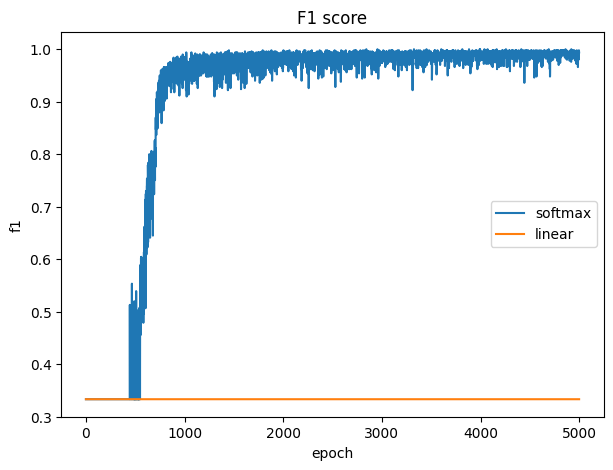

In [238]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(range(epochs), f1_softmax, label='softmax')
ax.plot(range(epochs), f1_linear, label='linear')
# ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('f1')
ax.set_title('F1 score')
ax.legend()
plt.show()